In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl, pandas as pd, numpy as np, geopandas as gpd, matplotlib.pyplot as plt

from math import sqrt
import pylab
import ast
import networkx as nx
pd.set_option('precision', 2)
pd.options.display.float_format = '{:20.2f}'.format
from matplotlib.colors import LinearSegmentedColormap

In [2]:
import cityImage as ci
import ABManalysis as af

## 0.0 Loading Shapefile

In [3]:
# initialise path, names, etc.
city_name = 'Muenster'
epsg = 25832
crs = 'EPSG:'+str(epsg)

In [35]:
input_path = 'Input/empiricalABM/'+city_name
output_path = 'Outputs/empiricalABM/'+city_name

edges = gpd.read_file(input_path+'_edges.shp', driver='ESRI Shapefile')
nodes = gpd.read_file(input_path+'_nodes.shp', driver='ESRI Shapefile')

nodes.index, edges.index = nodes.nodeID, edges.edgeID
nodes.index.name, edges.index.name = None, None

## 0.1 Loading  the simulation's volumes

In [36]:
summary_clusters = pd.read_csv(output_path+'_clusters.csv', index_col = 0)
clusters = ['group0', 'group1', 'group2', 'group3', 'group4', 'group5']
columns = ['edgeID'] + summary_clusters.index.to_list() + ['hetero']
runs = 5
df_list = []

for run in range(runs):
    df_tmp = pd.read_csv(input_path+'_PedSim_empirical_DMA_211002_'+str(run)+'.csv')
    df_tmp['hetero'] = df_tmp[clusters].sum(axis=1)
    for n, c in enumerate(columns): 
        df_tmp.rename(columns={c: columns[n]+"_"+str(run)}, inplace=True)
    df_list.append(df_tmp)
    
df = pd.concat(df_list, axis = 1)
df['edgeID'] = df.edgeID_0
for run in range(runs): 
    df.drop(['edgeID'+"_"+str(run)], axis = 1, inplace = True)
    
df_list = []
configurations = ['nullGroup', 'population', 'hetero']
for configuration in configurations: 
    df_list.append(df[[col for col in df if col.startswith(configuration)]+['edgeID']])
    
# aggregate runs values
edges = af.aggregate_runs(df_list, configurations, edges, ddof = 0)

## 0.2 Loading the simulation's resulting routes

In [39]:
input_path_routes = 'Input/empiricalABM/routes/'+city_name
routes_gdfs = []

for run in range(runs):
    run_gdf = gpd.read_file(input_path_routes+'_PedSim_empirical_DMA_211002_'+str(run)+'.shp')
    run_gdf.set_crs(crs)
    
    for n, configuration in enumerate(configurations):
        if configuration == 'hetero':
            configuration_gdf = run_gdf[run_gdf.group.isin(clusters)].copy()
        else:
            configuration_gdf = run_gdf[run_gdf.group == configuration].copy()
        if run == 0:
            routes_gdf = configuration_gdf.copy()
            routes_gdfs.append(configuration_gdf)
            continue
        
        routes_gdf = routes_gdfs[n].copy()
        routes_gdf = routes_gdf.append(configuration_gdf)
        routes_gdf.reset_index(inplace = True, drop=True)
        routes_gdf = routes_gdf.where(pd.notnull(routes_gdf), None)
        routes_gdf.replace({"None":None}, inplace = True)
        routes_gdfs[n] = routes_gdf

In [40]:
# preparing the routes gdf
for n, configuration in enumerate(configurations): 
    routes_gdf = routes_gdfs[n].copy()
    routes_gdf['edgeIDs'] = routes_gdf.apply(lambda row: af.get_edgesID(row, routes_gdf.columns) , axis = 1)
    routes_gdf['O'] = routes_gdf['O'].astype(int)
    routes_gdf['D'] = routes_gdf['D'].astype(int)
    routes_gdfs[n] = routes_gdf
    
# for n, configuration in enumerate(configurations):     
#     routes_gdf = routes_gdfs[n].copy()
#     routes_gdf[['ped', 'maj', 'bar', 'districts']] = routes_gdf.apply(lambda row: af.regionBased_variables(row['edgeIDs'],
#                                            row['geometry'], nodes,  edges), axis = 1, result_type='expand')
#     routes_gdfs[n] = routes_gdf

## 1 Computing statistics of each route
### 1.1 Deviation from the road-distance shortest path

In [41]:
graph = ci.graph_fromGDF(nodes, edges, nodeID = "nodeID")
distances = {}
routes_gdf = routes_gdfs[0].copy()
for routes_gdf in routes_gdfs:
    for row in routes_gdf.itertuples():
        source = routes_gdf.loc[row[0]]['O']
        target = routes_gdf.loc[row[0]]['D']
        if str(source)+"-"+str(target) in distances:
            continue
        distance = nx.shortest_path_length(graph, source=source, target=target, weight='length', method='dijkstra')
        distances[str(source)+"-"+str(target)] = distance

## 2 Getting the statistics
### 2.1 Deviation from the road-distance shortest path

In [546]:
variables = ['barrier', 'routeMark', 'regions', 'distant']

for cluster in clusters:
    print(cluster)
    tmp = routes_gdfs[2][routes_gdfs[2].group == cluster].copy()
    l = len(tmp)
    for variable in variables:
        print(variable, str(round(len(tmp[tmp[variable] == 1])/l*100,2)) +"%")
    
    tmp["using"] = tmp.barrier +tmp.routeMark + tmp.regions + tmp.distant
    print("using elements", str(round(len(tmp[tmp["using"] > 0])/l*100,2))+"%")
    print("severing", round(tmp.severing.mean(),3))
    print("natural",  round(tmp.natural.mean(),3))
    print()
    
for n, configuration in enumerate(configurations):
    print(configuration)
    for variable in variables:
        l = len(routes_gdfs[n])
        print(variable, str(round(len(routes_gdfs[n][(routes_gdfs[n][variable] == 1)])/l*100,2))+"%")
    
    routes_gdfs[n]["using"] = routes_gdfs[n].barrier +routes_gdfs[n].routeMark + routes_gdfs[n].regions + routes_gdfs[n].distant
    print("using elements", str(round(len(routes_gdfs[n][(routes_gdfs[n]["using"] > 0)])/l*100,2))+"%")
    print("severing", round(routes_gdfs[n].severing.mean(),3))
    print("natural",  round(routes_gdfs[n].natural.mean(),3))
    print()

group0
barrier 21.32%
routeMark 32.03%
regions 20.82%
distant 16.7%
using elements 67.31%
severing 1.517
natural 0.54

group1
barrier 28.4%
routeMark 15.26%
regions 20.04%
distant 34.08%
using elements 66.45%
severing 1.52
natural 0.496

group2
barrier 20.91%
routeMark 12.74%
regions 14.11%
distant 34.37%
using elements 57.11%
severing 1.46
natural 0.496

group3
barrier 13.16%
routeMark 22.14%
regions 25.61%
distant 29.49%
using elements 61.66%
severing 1.642
natural 0.5

group4
barrier 7.3%
routeMark 37.7%
regions 23.17%
distant 12.06%
using elements 60.08%
severing 1.5
natural 0.565

group5
barrier 16.92%
routeMark 29.87%
regions 11.7%
distant 22.99%
using elements 60.22%
severing 1.557
natural 0.524

nullGroup
barrier 18.17%
routeMark 18.6%
regions 23.55%
distant 27.14%
using elements 49.53%
severing 1.503
natural 0.501

population
barrier 20.49%
routeMark 20.75%
regions 19.36%
distant 28.87%
using elements 62.57%
severing 1.537
natural 0.509

hetero
barrier 20.03%
routeMark 21.33%


In [42]:
for n, configuration in enumerate(configurations):

    routes_gdf = routes_gdfs[n].copy()
    if configuration == 'hetero':
        for cluster in list(clusters):
            group_gdf = routes_gdf[routes_gdf.group == cluster].copy()
            print("   in ", cluster)
            print("median routes' lenght:", round(group_gdf.geometry.length.median(),3))
            print("mean routes' lenght:", round(group_gdf.geometry.length.mean(),3))
            group_gdf['sp_dist'] = group_gdf.apply(lambda row: distances[str(row['O'])+"-"+str(row['D'])], axis = 1)
            group_gdf['sp_dev'] = group_gdf.geometry.length/group_gdf['sp_dist']
            print("median routes' deviation from SP", round(group_gdf['sp_dev'].median(),3))
    print()
    print(configuration)
    print("median routes' lenght:", round(routes_gdf.geometry.length.median(),3))
    print("mean routes' lenght:", round(routes_gdf.geometry.length.mean(),3))
    routes_gdf['sp_dist'] = routes_gdf.apply(lambda row: distances[str(row['O'])+"-"+str(row['D'])], axis = 1)
    routes_gdf['sp_dev'] = routes_gdf.geometry.length/routes_gdf['sp_dist']
    print("median routes' deviation from SP", round(routes_gdf['sp_dev'].median(),3))
    print()
    routes_gdfs[n] = routes_gdf


nullGroup
median routes' lenght: 2079.365
mean routes' lenght: 2034.848
median routes' deviation from SP 1.003


population
median routes' lenght: 2411.012
mean routes' lenght: 2426.322
median routes' deviation from SP 1.12

   in  group0
median routes' lenght: 2421.701
mean routes' lenght: 2527.816
median routes' deviation from SP 1.133
   in  group1
median routes' lenght: 2416.244
mean routes' lenght: 2543.035
median routes' deviation from SP 1.108
   in  group2
median routes' lenght: 2500.838
mean routes' lenght: 2578.223
median routes' deviation from SP 1.09
   in  group3
median routes' lenght: 2295.614
mean routes' lenght: 2395.924
median routes' deviation from SP 1.06
   in  group4
median routes' lenght: 2376.4
mean routes' lenght: 2475.061
median routes' deviation from SP 1.1
   in  group5
median routes' lenght: 2467.398
mean routes' lenght: 2542.326
median routes' deviation from SP 1.147

hetero
median routes' lenght: 2409.31
mean routes' lenght: 2511.061
median routes' deviat

### *Saving and Loading*

In [11]:
# export routes
for n, model in enumerate(route_choice_models):
    routes_gdfs[n]['ds_str'] = routes_gdfs[n]['districts'].astype(str)
    routes_gdfs[n].drop(['districts', 'edgeIDs'], axis = 1, errors = 'ignore').to_file(
        output_path+'_'+model+'_routes.shp', driver='ESRI Shapefile')

In [6]:
## reload routes
routes_gdfs = []
route_choice_models = ['AC', 'RB', 'BB', 'RBB']
for n, model in enumerate(route_choice_models):
    routes_gdf = gpd.read_file(output_path+'_'+model+'_routes.shp', driver='ESRI Shapefile')
    routes_gdf['districts'] = [ast.literal_eval(i) for i in routes_gdf['ds_str']]
    routes_gdf['edgeIDs'] = routes_gdf.apply(lambda row: af.get_edgesID(row, routes_gdf.columns) , axis = 1)
    routes_gdfs.append(routes_gdf)

## 2. Volumes

### Saving volumes

In [576]:
edges.to_file(output_path+'_pedSim_empirical.shp', use_unicode=True, driver='ESRI Shapefile')

## Visualisation

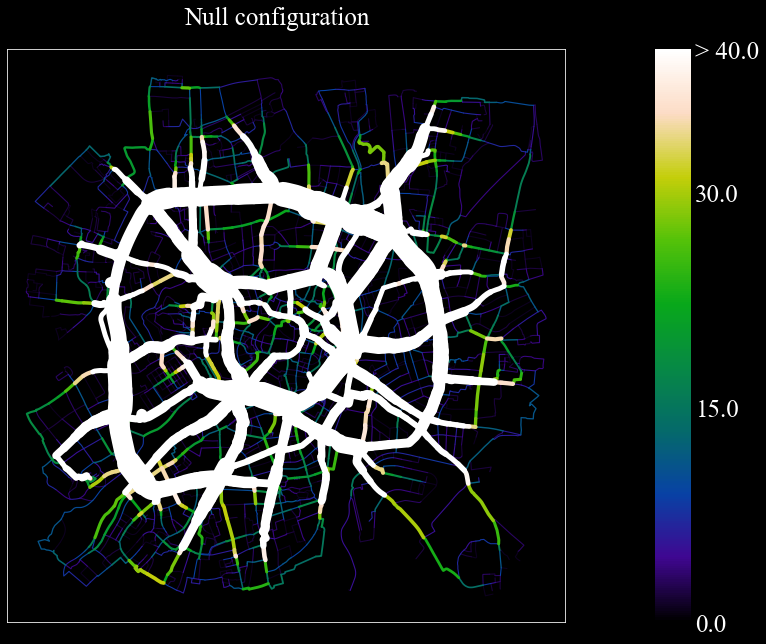

In [13]:
subtitles = ['Null configuration']
norm = mpl.colors.Normalize(vmin = 0, vmax = 40)
fig = ci.plot_gdf(edges, column = configurations[0], cmap = ci.kindlmann(), norm = norm, title = subtitles[0], fig_size = 10,
                       legend = False, cbar = True, cbar_ticks = 3, cbar_max_symbol = True, lw_factor = 0.12, axes_frame = True)

In [555]:
fig.savefig("Outputs/Figures/empiricalABM/f6.pdf", bbox_inches='tight')

In [21]:
configurations

['nullGroup', 'population', 'hetero']

In [23]:
edge_vis['nullGroup_%'] == edge_vis['population']

9        False
24       False
32       False
37       False
38       False
         ...  
30338     True
14590    False
15234    False
30300    False
30137    False
Length: 3904, dtype: bool

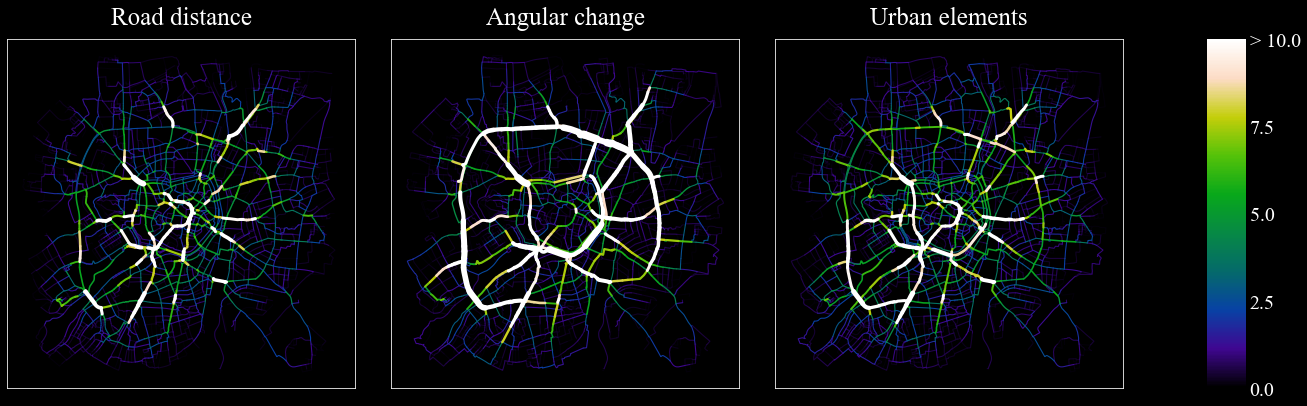

In [61]:
subtitles = [ 'Road distance', 'Angular change', 'Urban elements',]
cols = ['null', 'homo', 'hetero']

edge_vis = edges.copy()
cols = []
for col in configurations:
    edge_vis[col+"_%"] = edge_vis[col]/(1000)*100
    cols.append(col+"_%")

norm = mpl.colors.Normalize(vmin = 0, vmax = 10)

fig = ci.plot_gdf_grid(edge_vis, ncols = 3, fig_size = 20, columns = cols, cmap = ci.kindlmann(), titles = subtitles, 
                    norm = norm, legend = False, cbar = True, cbar_ticks = 4, cbar_max_symbol = True, lw_factor = 0.30, 
                    axes_frame = True,  black_background = True)

In [62]:
fig.savefig("Outputs/Figures/empiricalABM/f6_conf.jpg", dpi = 300, bbox_inches='tight')

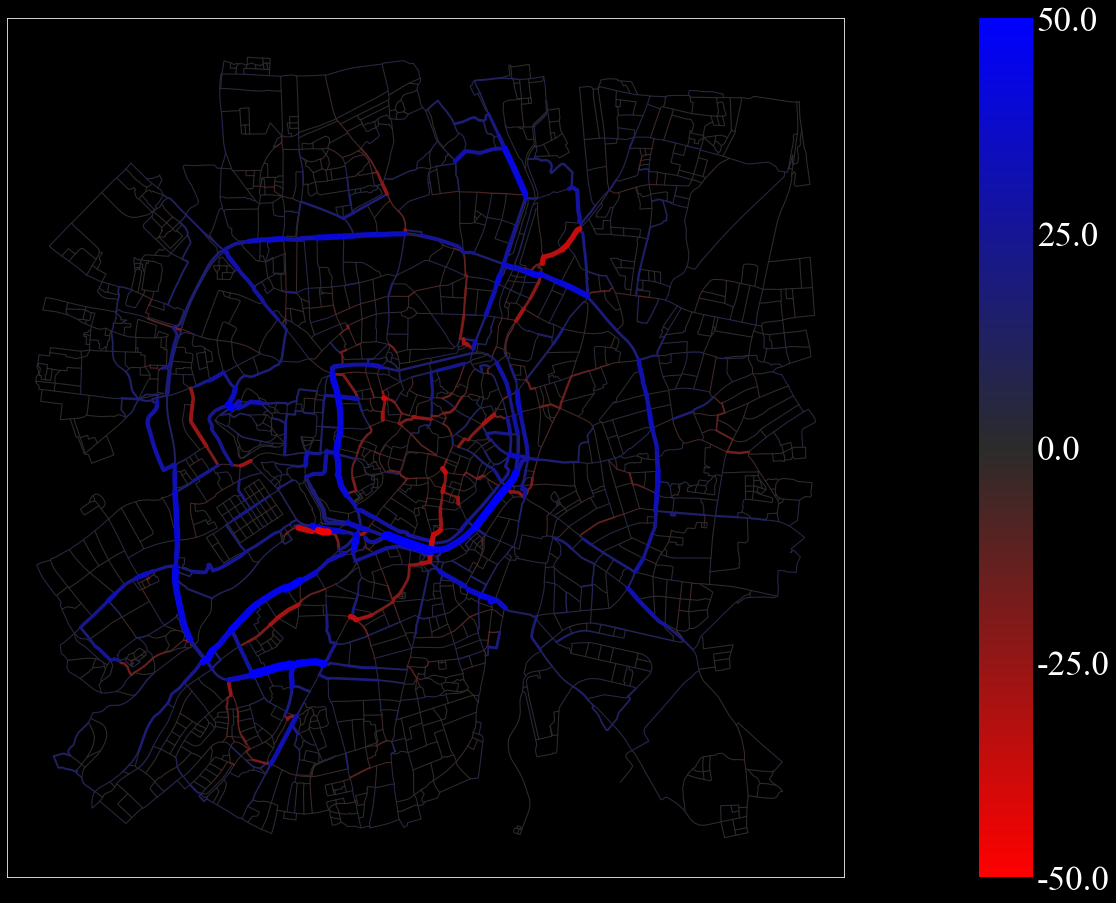

In [58]:
black_l = ci.lighten_color('black', 0.83)
subtitles = ['Homogeneous Configuration', 'Heterogeneous Configuration']
edges['hetero_diff'] = edges['hetero'] - edges['nullGroup']

norm = mpl.colors.Normalize(vmin = -50, vmax = 50)
cmap = LinearSegmentedColormap.from_list('BkR',['red', black_l,'blue',])

fig = ci.plot_gdf(edges, column = 'hetero_diff', cmap = cmap, norm = norm,
                       legend = False, cbar = True, cbar_ticks = 4, cbar_max_symbol = False, lw_factor = 0.15,
                       axes_frame = True, black_background = True)

In [560]:
fig.savefig("Outputs/Figures/empiricalABM/f7.pdf", bbox_inches='tight')

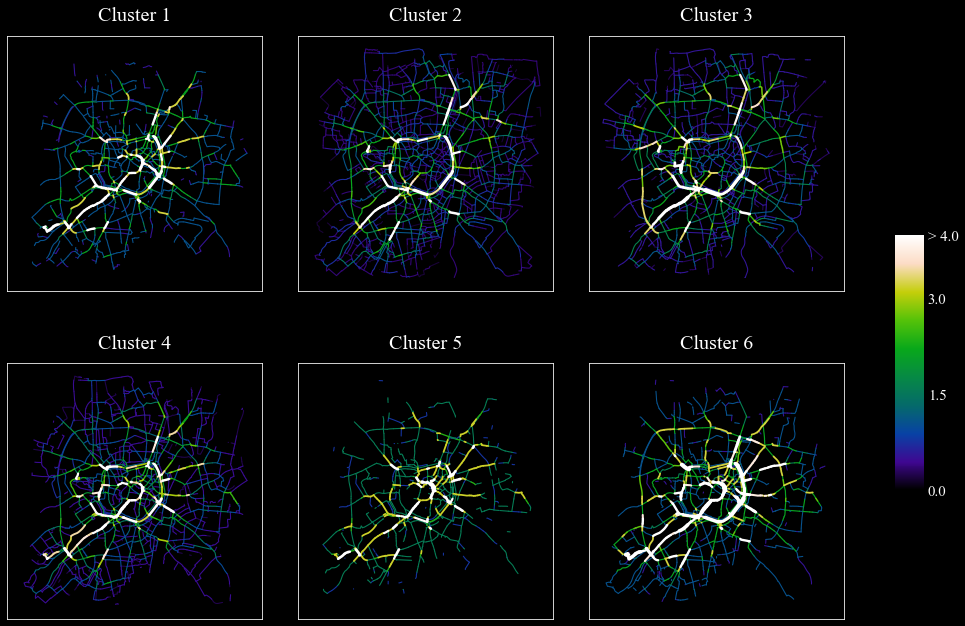

In [15]:
for cluster in clusters:
    edges_clusters[cluster+"_%"] = edges_clusters[cluster]/(301*summary_clusters.loc[cluster].portion*3)*100

# edges_clusters['hetero'] = edges['hetero']/(301*3)*100
columns = [cluster+"_%" for cluster in clusters]
titles = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5', 'Cluster 6']

norm = mpl.colors.Normalize(vmin = 0, vmax = 4)
fig = ci.plot_gdf_grid(edges_clusters, ncols = 3, fig_size = 15, columns = columns, titles = titles, cmap = ci.kindlmann(), 
                    norm = norm, legend = False, cbar = True, cbar_ticks = 3, cbar_max_symbol = True, lw_factor = 0.55, 
                    axes_frame = True,  black_background = True)

In [16]:
fig.savefig("Outputs/Figures/empiricalABM/f8h.pdf", bbox_inches='tight')

In [19]:
fig.savefig("Outputs/Figures/empiricalABM/f8h.tif", bbox_inches='tight', dpi = 300)

## Statistics

In [57]:
import pysal as ps
subtitles = [ 'Null Configuration', 't', 'Heteregeneous Configuration',]

for n, configuration in enumerate(configurations):
    print(subtitles[n], 'mean is', round(edges[configuration].mean(),2))
    print(subtitles[n], 'STD is', round(edges[configuration].std(),2))
    print(subtitles[n], 'max is', round(edges[configuration].max(),2))
    sg = ps.explore.inequality.gini.Gini(list(edges[configuration]))
    print(subtitles[n], 'Gini coefficient is', round(sg.g,2))
    print()

Null Configuration mean is 18.75
Null Configuration STD is 23.98
Null Configuration max is 188.0
Null Configuration Gini coefficient is 0.61

t mean is 18.3
t STD is 32.58
t max is 260.0
t Gini coefficient is 0.71

Heteregeneous Configuration mean is 21.46
Heteregeneous Configuration STD is 25.54
Heteregeneous Configuration max is 185.0
Heteregeneous Configuration Gini coefficient is 0.57



In [565]:
city_centre = gpd.read_file("Input/empiricalABM/Muenster_city_centre.shp")
edges_cc = edges[edges.geometry.within(city_centre.iloc[0].geometry.buffer(50))].copy()

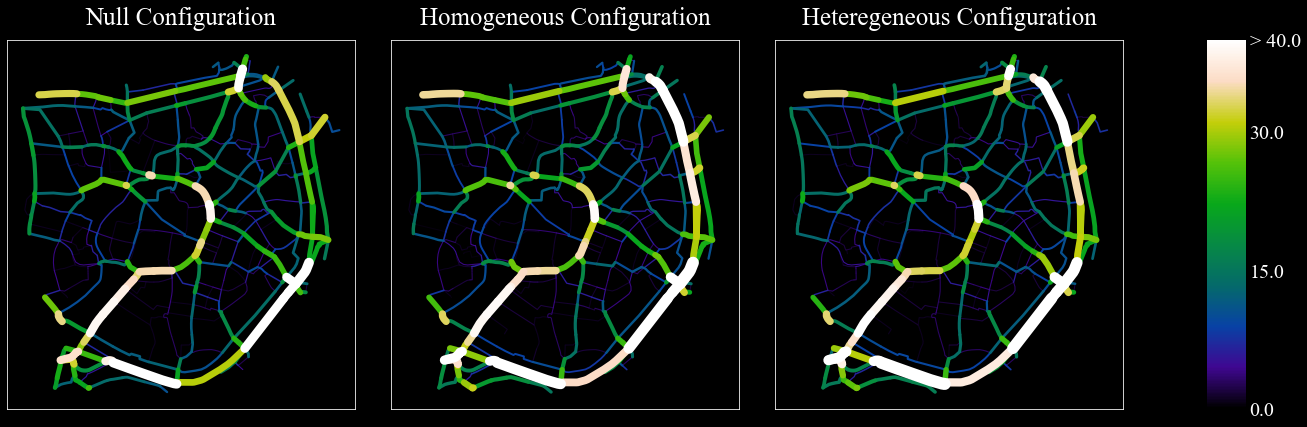

In [566]:
subtitles = ['Null Configuration','Homogeneous Configuration', 'Heteregeneous Configuration']

norm = mpl.colors.Normalize(vmin = 0, vmax = 40)
fig = ci.plot_gdf_grid(edges_cc, ncols = 3, fig_size = 20, columns = configurations, cmap = ci.kindlmann(), titles = subtitles,
                       lw_factor = 0.22, cbar = True, norm = norm, cbar_ticks = 3, cbar_max_symbol = True, axes_frame = True,
                       black_background = True)

### 2.2 Inequality - Gini Coefficient

In [567]:
not_null_configurations = ['hetero','population']
max_err = 5
edges = af.compute_deviation_from(edges, not_null_configurations, comparison = 'nullGroup', max_err = 10)

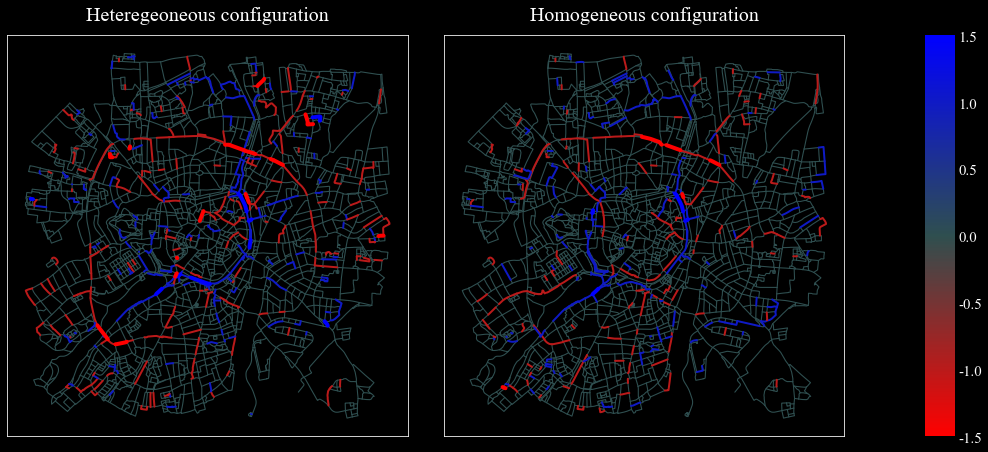

In [568]:
from matplotlib.colors import LinearSegmentedColormap
not_null_configurations_std = ['hetero_std_err', 'population_std_err']
titles = ['Heteregeoneous configuration', 'Homogeneous configuration']

## visualisation
cmap = LinearSegmentedColormap.from_list('BkR',['red', 'darkslategrey','blue',])
norm = mpl.colors.Normalize(vmin = -1.5, vmax = 1.5)
fig = ci.plot_gdf_grid(gdf = edges, columns = not_null_configurations_std, titles = titles, cbar = True,
                       norm = norm,  fig_size = 15, cmap = cmap, cbar_ticks = 6, cbar_max_symbol = False, 
                       axes_frame = True, lw_factor = 2.00, black_background = True)

## Loading OD-based simulation

In [203]:
input_path_routes = 'Input/empiricalABM/routes/'+city_name
OD_gdfs = []
runs = 10

run_gdf = gpd.read_file(input_path_routes+'_PedSim_empirical_OD_0.shp')
run_gdf.set_crs(crs)

for n, configuration in enumerate(configurations):
    if configuration == 'hetero':
        configuration_gdf = run_gdf[run_gdf.group.isin(groups)].copy()
    else:
        configuration_gdf = run_gdf[run_gdf.group == configuration].copy()
    
    OD_gdf = configuration_gdf.copy() 
    OD_gdf = OD_gdf.where(pd.notnull(OD_gdf), None)
    OD_gdf.replace({"None": None}, inplace = True)
    OD_gdfs.append(OD_gdf)
        
        
# # preparing the routes gdf
for n, configuration in enumerate(configurations): 
    OD_gdf = OD_gdfs[n].copy()
    OD_gdf['edgeIDs'] = OD_gdf.apply(lambda row: af.get_edgesID(row, OD_gdf.columns) , axis = 1)
    OD_gdf['O'] = OD_gdf['O'].astype(int)
    OD_gdf['D'] = OD_gdf['D'].astype(int)
    OD_gdfs[n] = OD_gdf

In [172]:
OD_gdfs[0].O.unique()

array([12368,  8803,  5176])

Null Configuration 0.036005470022260455
Homogeneous Configuration 0.036596452349735506
Heteregeneous Configuration 0.03461450772609079


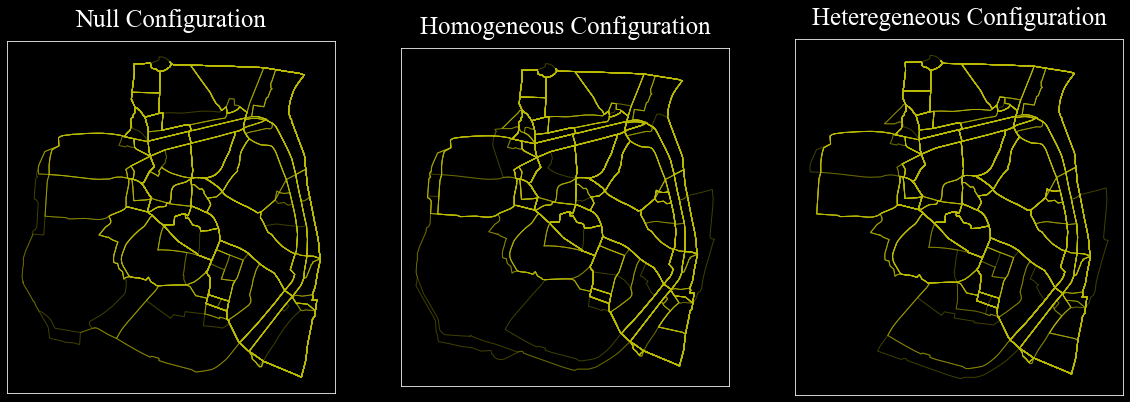

In [207]:
subtitles = ['Null Configuration', 'Homogeneous Configuration','Heteregeneous Configuration']
cols = ['homo_log', 'hetero_log', 'null_log']
norm = mpl.colors.Normalize(vmin = 0, vmax = 26)
tmp_gdfs = []
for n, gdf in enumerate(OD_gdfs):
    tmp = gdf[gdf.O == 12368].copy()
    tmp_gdfs.append(tmp)
    all_edges = [item for sublist in [edges for edges in tmp.edgeIDs] for item in sublist]
    all_edges = list(set(all_edges))
    lenght_covered = edges[edges.edgeID.isin(all_edges)].length.sum()
    print(subtitles[n], lenght_covered/tmp.length.sum())
    
fig = ci.plot_gdfs(tmp_gdfs, fig_size = 20, ncols = 3, color = 'y', titles = subtitles, axes_frame = True, alpha = 0.33,
                black_background = True)

In [ ]:
edges_OD = gpd.read_file(input_path+'_edges.shp', driver='ESRI Shapefile')

In [357]:
columns = ['edgeID'] + summary_clusters.index.to_list() + ['hetero']
runs = 10
df_list = []
for run in range(runs):
    df_tmp = pd.read_csv(input_path+'_PedSim_empirical_OD_'+str(run)+'.csv')
    groups = [col for col in df_tmp if col.startswith('group')]
    df_tmp['hetero'] = df_tmp[groups].sum(axis=1)
    for n, c in enumerate(columns): 
        df_tmp.rename(columns={c: columns[n]+"_"+str(run)}, inplace=True)
    df_list.append(df_tmp)
    
df = pd.concat(df_list, axis = 1)
df['edgeID'] = df.edgeID_0
for run in range(runs): 
    df.drop(['edgeID'+"_"+str(run)], axis = 1, inplace = True)
    
df_list = []
configurations = ['nullGroup', 'population', 'hetero']
for configuration in configurations: 
    df_list.append(df[[col for col in df if col.startswith(configuration)]+['edgeID']])
    
# aggregate runs values
edges_OD = af.aggregate_runs(df_list, configurations, edges, ddof = 0)

FileNotFoundError: [Errno 2] No such file or directory: 'Input/empiricalABM/Muenster_PedSim_empirical_OD_0.csv'

28770.802487949702